# Labeling

For each ticker, we want to label the best buy/sell/hold actions (this is the classification label we will train on).

This is the starting logic (before extra cases complicate it):

- iterate over prices for the ticker (over time)
- e.g. prices: 
- for the first record, we will buy 1 share at that price (this becomes our balance)
- for every following record:
    - if the current price is more than the previous price
        - action = "sell"
        - if previous action is "sell", set previous row action to "hold"
    - if the current price is less than the previous price
        - action = "buy"
        - if previous action is "buy", set previous row action to "hold"
    - keep track of cost basis and profit/loss based on current liquid and realized values

This will iterate like so over the following price list:

- prices = [20, 21, 22, 18, 17, 16, 17]
- actions = 
- buy
- buy, sell
- buy, hold, sell
- buy, hold, sell, buy
- buy, hold, sell, hold, buy
- buy, hold, sell, hold, hold, buy
- buy, hold, sell, hold, hold, buy, sell (final action list)
- $3 profit

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import os
import matplotlib.pylab as plt
# import logging
# logging.basicConfig()
# logging.getLogger().setLevel(logging.INFO)
# logging.getLogger('foo').debug('bah')
# logging.getLogger().setLevel(logging.DEBUG) 
# logging.getLogger('foo').debug('bah')

In [3]:
def label_actions(df, verbose=False, col='close', significance=0.10):
    df['buy'] = 0
    df['sell'] = 0
    df['hold'] = 0
    df['action'] = 'hold'
    holding=0
    cost_basis=0
    liquid=0
    profit=0
    buys=0
    sells=0
    last_basis=0
    last_row_i=-1
    last_quantity_sold=0
    last_profit=0
    first_row_i=0
    for i, row in df.iterrows():
        if last_row_i==-1:
            # first record: buy one
            buys=1
            holding=1
            cost_basis = row[col]
            df.set_value(i,'action','buy')
            first_row_i = i
        else:
            last_row = df.loc[last_row_i]
            last_sell = last_row.action=='sell'
            last_buy = last_row.action=='buy'
            price_same = row[col] == last_row[col]
            # TODO: also ensure price has changed at least 1%-5% or .05...or something
            # >= to catch moving the sell signal over a plateau 
            if (row[col] >= cost_basis) & ((row[col] > last_row[col]) | (price_same & last_sell)):
                df.set_value(i,'action','sell')
                if last_row.action == "sell":
                    df.set_value(last_row_i,'action','hold')
                    # remove the recorded profit from the last sale
                    profit -= last_profit
                    # add the profit from selling at this price
                    last_profit=(last_quantity_sold * (row[col] - last_basis))
                    profit += last_profit
                else:
#                     significant = (row[col] - last_row[col] > significance)
#                     if significant:
                        if holding == 0:
                           print('!!!!!!!!!!!!Anomaly!!') 
                        last_quantity_sold=holding
                        last_profit=(holding * (row[col] - cost_basis))
                        profit += last_profit
                        sells += 1
                        last_basis=cost_basis
                        holding = 0
                        cost_basis = 0
            elif ((cost_basis==0) | (row[col] <= cost_basis)) & ((row[col] < last_row[col]) | (price_same & last_buy)):
                df.set_value(i,'action','buy')
                if (last_row.action == "buy"):
                    
                    # update the first entry to a sell if the price went down (significantly?)
                    if (last_row_i == first_row_i) & (not price_same):
                        df.set_value(last_row_i,'action','sell')
                    else:
                        df.set_value(last_row_i,'action','hold')
                    # adjust the recorded cost-basis to the new cost
                    last_held = holding-1
                    if last_held==0:
                        cost_basis = row[col]
                    else:
                        cost_basis = ((last_basis * last_held) + row[col]) / (holding)
                    last_basis=cost_basis
                else:
#                     significant = (last_row[col] - row[col] > significance)
#                     if(significant):
                        last_basis = cost_basis
                        if holding==0:
                            cost_basis = row[col]
                        else:
                            cost_basis = ((cost_basis * holding) + row[col]) / (holding+1)
                        holding += 1
                        buys += 1
                    
        if verbose:
            print(df.get_value(i,'action'), "\tclose: {0:.2f}".format(row[col]), '\tholding:', holding, "\tbasis: {0:.2f}".format(cost_basis),"\tlast basis: {0:.2f}".format(last_basis), "\tprofit: {0:.4f}".format(profit))
#             print(row['4h_rsi'], row['4h_stochrsi'])
        last_row_i = i
        liquid = (row[col]*holding) - (cost_basis*holding) + profit

    print("holding:", holding, "\tbasis:", "{0:.2f}".format(cost_basis), "\trealized:", "{0:.2f}".format(profit), "\tliquid:","{0:.2f}".format(liquid), "\tbuys:", buys, "\tsells:",sells)
    # correct the single word label into a binary multi-label
    df['buy'] = df['action']=='buy'
    df['sell'] = df['action']=='sell'
    df['hold'] = df['action']=='hold'
    df['buy'] = df['buy'].astype(int)
    df['sell'] = df['sell'].astype(int)
    df['hold'] = df['hold'].astype(int)
    df.drop(['action'], axis=1, inplace=True)
    return df

In [6]:
indicators=['price','STOCHRSI','RSI','CCI']

In [7]:
dfs={}
for ind in indicators:
    dfs[ind] = pd.read_csv('timeseries/GOOG.daily.'+ind+'.csv',index_col=None)
    if 'time' in dfs[ind]:
#         print(dfs[ind].time.str.split(" ").str.get(0))
        dfs[ind]['timestamp'] = dfs[ind]['time'].replace(regex=r'\s.+$', value='')
#         dfs[ind].timestamp = dfs[ind].time.str.split().str.get(0)
        dfs[ind].drop('time', axis=1, inplace=True)
    dfs[ind].timestamp = pd.to_datetime(dfs[ind].timestamp)
    dfs[ind].set_index('timestamp', inplace=True)
    print(ind,dfs[ind].head(2))

price                open     high      low    close  volume
timestamp                                             
2019-04-12  1210.00  1218.35  1208.11  1217.87  888875
2019-04-11  1203.96  1207.96  1200.13  1204.62  709417
STOCHRSI               FastD    FastK
timestamp                   
2019-04-12  59.4707  100.000
2019-04-11  26.1373   57.293
RSI                 RSI
timestamp          
2019-04-11  58.9161
2019-04-10  57.9223
CCI                 CCI
timestamp          
2019-04-11  41.7866
2019-04-10  25.8297


In [8]:
df = pd.concat(dfs, axis=1,verify_integrity=True,join="inner")
df.columns = df.columns.get_level_values(1)

df.head(5)

,CCI,RSI,FastD,FastK,open,high,low,close,volume
timestamp,,,,,,,,,
2019-04-11,41.7866,58.9161,26.1373,57.2930,1203.96,1207.96,1200.13,1204.62,709417
2019-04-10,25.8297,57.9223,7.0397,21.1191,1200.68,1203.79,1196.43,1202.16,724643
2019-04-09,9.4152,56.2648,11.9620,0.0000,1196.00,1202.29,1193.08,1197.25,876381
2019-04-08,48.4166,59.1696,45.2953,0.0000,1207.89,1208.69,1199.86,1203.84,860363
2019-04-05,82.4411,60.6295,78.6286,35.8859,1214.99,1216.22,1205.03,1207.15,907152


In [9]:
df.columns

Index(['CCI', 'RSI', 'FastD', 'FastK', 'open', 'high', 'low', 'close',
       'volume'],
      dtype='object')

In [10]:
# drop NaN columns (where we didn't have RSI, Stoch, etc for the price, or vice-versa)
df.dropna(inplace=True)
# drop the newest record (partial day data if intraday)
# df = df.iloc[1:]
# reverse order to oldest -> newest
# df = df.iloc[::-1]
# drop the oldest record (comparisons to previous will be maxed-out)
# df = df.iloc[1:]
df = df.sort_index()
df.head(5)

,CCI,RSI,FastD,FastK,open,high,low,close,volume
timestamp,,,,,,,,,
2014-04-25,-124.2517,37.0068,0.7509,0.0000,522.51,524.70,515.42,516.18,2094600
2014-04-28,-134.4773,37.5152,2.9174,8.7522,517.18,518.60,502.80,517.15,3326400
2014-04-29,-76.6991,42.9115,36.2507,100.0000,516.90,529.46,516.32,527.70,2691700
2014-04-30,-66.6859,42.5216,67.3833,93.3976,527.60,528.00,522.52,526.66,1746400
2014-05-01,-44.4134,44.9505,97.7992,100.0000,527.11,532.93,523.88,531.35,1900300


In [11]:
# export truth
df.to_csv('./GOOG_joined.csv', header=None, index=None)

In [12]:
# testing
df_labeled = label_actions(df, col='close', verbose=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


holding: 0 	basis: 0.00 	realized: 5539.61 	liquid: 5539.61 	buys: 308 	sells: 308


In [13]:
df_labeled.head(3)

,CCI,RSI,FastD,FastK,open,high,low,close,volume,buy,sell,hold
timestamp,,,,,,,,,,,,
2014-04-25,-124.2517,37.0068,0.7509,0.0000,522.51,524.70,515.42,516.18,2094600,1,0,0
2014-04-28,-134.4773,37.5152,2.9174,8.7522,517.18,518.60,502.80,517.15,3326400,0,0,1
2014-04-29,-76.6991,42.9115,36.2507,100.0000,516.90,529.46,516.32,527.70,2691700,0,1,0


<IPython.core.display.Javascript object>


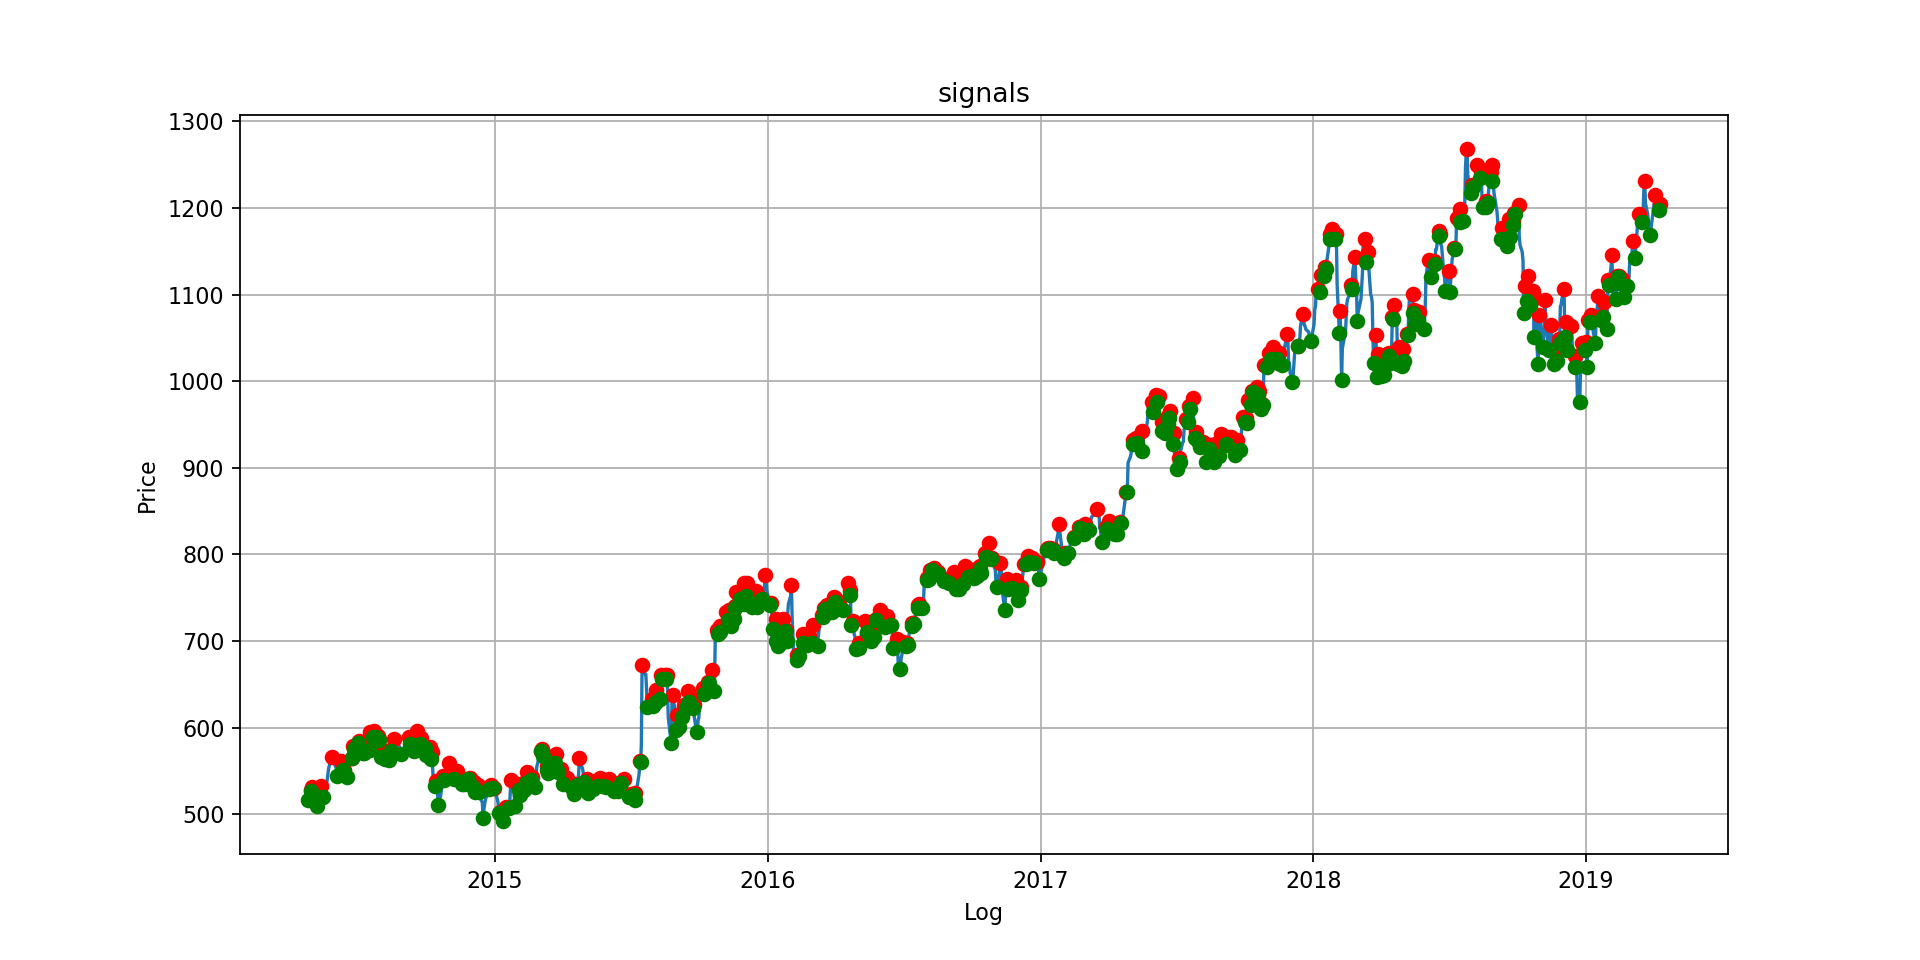

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [14]:
%matplotlib notebook

df_temp = df_labeled

plt.figure(1, figsize=(12, 6), dpi=80)
plt.title('signals')
plt.xlabel('Log')
plt.ylabel('Price')
plt.plot(df_temp.close)
plt.plot(df_temp[df_temp.sell==1].close, 'ro', label='sell')
plt.plot(df_temp[df_temp.buy==1].close, 'go', label='buy')
plt.grid(True)
plt.show()

In [ ]:
# export truth
df_labeled.to_csv('./labeled_GOOG.csv')